In [40]:
# Librerías para manipulación de archivos y rutas en SO
import os , os.path

# Librerías para manipulación y análisis de datos
import pandas as pd
import numpy as np
import pickle

# Librerías para manipulación de imágenes
from PIL import Image, ImageOps
import PIL
import keras.utils as image

# Librerías para visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías para preprocesamiento y modelado de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator

# Librerías para construcción y entrenamiento de modelos de deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping


Cargamos la base de datos previamente generada en el archivo .py

In [2]:
with open('my_dataframe.pkl', 'rb') as file:
    df = pickle.load(file)

Hacemos un recuento de los generos.

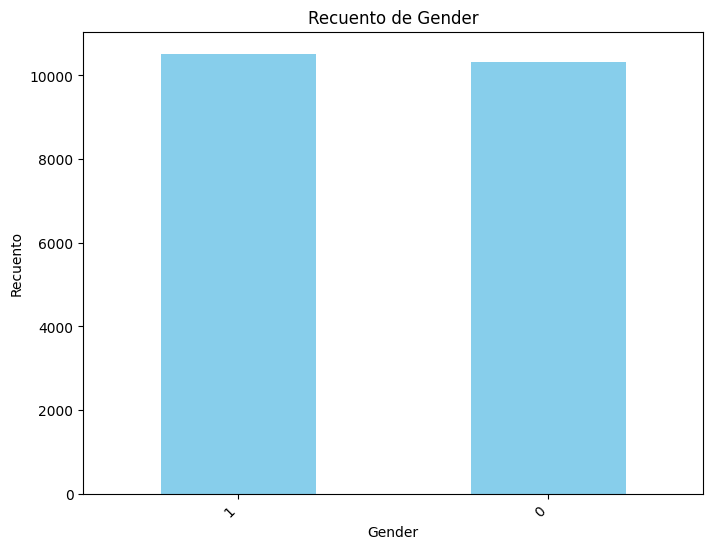

In [3]:
# Calcula el recuento de valores únicos en la columna 'Genders' del DataFrame 'df'
recuento_genero = df['Genders'].value_counts()

# Crea un gráfico de barras para visualizar el recuento de géneros
plt.figure(figsize=(8, 6))  # Establece el tamaño de la figura
recuento_genero.plot(kind='bar', color='skyblue')  # Crea el gráfico de barras
plt.title('Recuento de Género')  # Establece el título del gráfico
plt.xlabel('Género')  # Etiqueta del eje x
plt.ylabel('Recuento')  # Etiqueta del eje y
plt.xticks(rotation=45, ha='right')  # Rotación de las etiquetas del eje x para una mejor legibilidad
plt.show()  # Muestra el gráfico

Redimensionamos las imagenes procedentes del dataframe:
X lleva las imagenes
Y las etiquetas que usaremos en el modelo

In [4]:
x = []
y = []
z = []

for i in range(len(df)):
    # Carga la imagen desde el DataFrame
    imagen_pil = df['Images'].iloc[i]

    # Redimensiona la imagen a (200, 200) usando el filtro Lanczos,redimensionamiento de alta calidad.
    imagen_redimensionada = imagen_pil.resize((200, 200), Image.LANCZOS)
    
    # Convierte la imagen redimensionada a un arreglo NumPy
    ar = np.array(imagen_redimensionada)
    
    # Asegúrate de que todas las imágenes tengan la misma forma (200, 200, 3)
    if ar.shape == (200, 200, 3):
        # Agrega el arreglo al  x
        x.append(ar)
    else:
        z.append(i)

# Convierte las listas x e y en arreglos NumPy
x = np.array(x)
y = df['Genders']


Guardamos en la variable Z las imagenes que no son posibles de redimensionar

In [5]:
df.drop(z, inplace=True)

Recoge en un arreglo de numpy todos los valores, sincronizandose con la X

In [7]:
y = df['Genders'].values 

In [9]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
# X_train: Conjunto de datos de entrenamiento (imágenes)
# X_test: Conjunto de datos de prueba (imágenes)
# y_train: Etiquetas correspondientes al conjunto de entrenamiento
# y_test: Etiquetas correspondientes al conjunto de prueba
# Se utiliza train_test_split para dividir los datos, donde:
# x: conjunto de imágenes
# y: etiquetas de género
# test_size=0.2: Tamaño del conjunto de prueba, en este caso el 20% de los datos se utilizan para pruebas
# random_state=42: Semilla para la generación de números aleatorios, asegurando reproducibilidad en la división de datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


CREAMOS EL MODELO CON SALIDA SIGMOID

In [11]:
# Inicialización del modelo secuencial
genmodel = Sequential()

# Capa convolucional 1
genmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(BatchNormalization())# Capa de normalización por lotes
genmodel.add(Dropout(0.2))# Capa de abandono para regularización
genmodel.add(MaxPooling2D((2, 2)))# Capa de agrupación máxima
# Capa convolucional 2
genmodel.add(Conv2D(64, (3, 3), activation='relu'))
genmodel.add(BatchNormalization())# Capa de normalización por lotes
genmodel.add(Dropout(0.2))# Capa de abandono para regularización
genmodel.add(MaxPooling2D((2, 2)))# Capa de agrupación máxima
# Capa convolucional 3
genmodel.add(Conv2D(128, (3, 3), activation='relu'))
genmodel.add(BatchNormalization())# Capa de normalización por lotes
genmodel.add(Dropout(0.2))# Capa de abandono para regularización
genmodel.add(MaxPooling2D((2, 2)))# Capa de agrupación máxima
genmodel.add(Flatten())# Aplanamiento de la salida para conectarla a una capa densa


# Capa densa totalmente conectada
genmodel.add(Dense(128, activation='relu'))
genmodel.add(BatchNormalization())# Capa de normalización por lotes
genmodel.add(Dropout(0.2))# Capa de abandono para regularización
# Capa de salida con activación sigmoidal para clasificación binaria
genmodel.add(Dense(1, activation='sigmoid'))
# Compilación del modelo
genmodel.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(),
                 metrics=['accuracy'])


2024-01-25 09:00:38.798199: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
# tf.keras.backend.clear_session() para reiniciar la sesion

Creamos un early stopping 

In [12]:
# Definición de EarlyStopping
# monitor='val_loss': La métrica que se va a monitorear durante el entrenamiento. En este caso, se controla la pérdida en el conjunto de validación.
# patience=5: Si no hay mejora después de estas épocas, el entrenamiento se detiene.
# restore_best_weights=True: Especifica si restaurar los pesos del modelo a la mejor época observada. 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [13]:
# Entrenamiento del modelo
# X_train: Conjunto de datos de entrenamiento (imágenes)
# y_train: Etiquetas correspondientes al conjunto de entrenamiento (Genero)
# epochs=30: Número de épocas (iteraciones completas sobre el conjunto de datos de entrenamiento)
# batch_size=16: Tamaño del lote de datos de entrenamiento que se utiliza en cada iteración
# shuffle=True: Barajar los datos de entrenamiento en cada época para evitar el sesgo del modelo
# verbose=1: Nivel de verbosidad durante el entrenamiento (muestra una barra de progreso por época)
# validation_split=0.2: Proporción de los datos de entrenamiento que se utilizarán como conjunto de validación
# callbacks=early_stopping: Utiliza la técnica de EarlyStopping definida previamente para detener el entrenamiento si no hay mejora en la pérdida en el conjunto de validación
history = genmodel.fit(X_train, y_train, epochs=30, batch_size=32, shuffle=True, verbose=1, validation_split=0.2, callbacks=early_stopping)


Epoch 1/30
417/417 [==============================] - 100s 236ms/step - loss: 0.6691 - accuracy: 0.6442 - val_loss: 0.7045 - val_accuracy: 0.6790
Epoch 2/30
417/417 [==============================] - 98s 236ms/step - loss: 0.5427 - accuracy: 0.7252 - val_loss: 1.1442 - val_accuracy: 0.6916
Epoch 3/30
417/417 [==============================] - 99s 237ms/step - loss: 0.4971 - accuracy: 0.7507 - val_loss: 0.6416 - val_accuracy: 0.6871
Epoch 4/30
417/417 [==============================] - 99s 237ms/step - loss: 0.4683 - accuracy: 0.7732 - val_loss: 0.5423 - val_accuracy: 0.7486
Epoch 5/30
417/417 [==============================] - 99s 236ms/step - loss: 0.3902 - accuracy: 0.8224 - val_loss: 0.5760 - val_accuracy: 0.7411
Epoch 6/30
417/417 [==============================] - 99s 236ms/step - loss: 0.3219 - accuracy: 0.8599 - val_loss: 0.9499 - val_accuracy: 0.7480
Epoch 7/30
417/417 [==============================] - 99s 237ms/step - loss: 0.2666 - accuracy: 0.8871 - val_loss: 0.7620 - val_a

Evaluacion del primer modelo

In [14]:
# Evaluación del modelo en el conjunto de datos de prueba
# X_test: Conjunto de datos de prueba (imágenes)
# y_test: Etiquetas correspondientes al conjunto de prueba
resultado_evaluacion = genmodel.evaluate(X_test, y_test)


  1/131 [..............................] - ETA: 10s - loss: 0.6248 - accuracy: 0.6875

131/131 [==============================] - 8s 57ms/step - loss: 0.5752 - accuracy: 0.7391


[0.575210452079773, 0.7391408681869507]

OPTIMIZAMOS CON NUEVOS HIPERPARAMETROS (DATA AUMENTATION)

In [15]:
# Data augmentation para el conjunto de entrenamiento
datagen = ImageDataGenerator(
    rescale=1./255.,  # Reescala los valores de píxeles al rango [0, 1]
    width_shift_range=0.1,  # Desplazamiento horizontal aleatorio de las imágenes
    height_shift_range=0.1,  # Desplazamiento vertical aleatorio de las imágenes
    horizontal_flip=True  # Volteo horizontal aleatorio de las imágenes
)

# Preprocesamiento simple para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

# Generación de flujos de datos para el conjunto de entrenamiento y prueba
train2 = datagen.flow(X_train, y_train, batch_size=32)  # Flujos de datos para el conjunto de entrenamiento
test2 = test_datagen.flow(X_test, y_test, batch_size=32)  # Flujos de datos para el conjunto de prueba

# Entrenamiento del modelo con los flujos de datos generados
history2 = genmodel.fit(
    train2,  # Flujos de datos de entrenamiento
    epochs=25,  # Número de épocas de entrenamiento
    shuffle=True,  # Barajear los datos en cada época
    validation_data=test2,  # Flujos de datos de validación
    callbacks=[early_stopping]  # Lista de devoluciones de llamada, incluida la técnica de EarlyStopping
)


Epoch 1/25


2024-01-25 09:16:48.233948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


521/521 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7308

2024-01-25 09:19:13.661446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


521/521 [==============================] - 153s 292ms/step - loss: 0.5256 - accuracy: 0.7308 - val_loss: 1.7756 - val_accuracy: 0.4963
Epoch 2/25
521/521 [==============================] - 151s 290ms/step - loss: 0.4869 - accuracy: 0.7595 - val_loss: 0.6959 - val_accuracy: 0.6542
Epoch 3/25
521/521 [==============================] - 152s 291ms/step - loss: 0.4640 - accuracy: 0.7707 - val_loss: 0.6953 - val_accuracy: 0.6347
Epoch 4/25
521/521 [==============================] - 152s 291ms/step - loss: 0.4595 - accuracy: 0.7753 - val_loss: 0.9436 - val_accuracy: 0.7442
Epoch 5/25
521/521 [==============================] - 151s 290ms/step - loss: 0.4349 - accuracy: 0.7909 - val_loss: 0.9856 - val_accuracy: 0.6355
Epoch 6/25
521/521 [==============================] - 151s 289ms/step - loss: 0.4237 - accuracy: 0.7974 - val_loss: 0.5416 - val_accuracy: 0.7531
Epoch 7/25
521/521 [==============================] - 151s 289ms/step - loss: 0.4038 - accuracy: 0.8101 - val_loss: 0.5204 - val_accura

Comprobamos cual es el mejor epoch

In [17]:
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"La mejor época fue la número {best_epoch}")
# Se sumo uno porque los indices de python comienzan en 0 y las epocas por 1

La mejor época fue la número 4


Guardamos modelo ya que da buenos resultados

In [39]:
genmodel.save('modelogenero.h5')

Redimensionamos la imagen que queramos predecir

In [35]:
# Cargar la imagen y redimensionarla al tamaño deseado (200x200 píxeles)
img = image.load_img('FotosTest/alyson.png', target_size=(200, 200))

# Convertir la imagen a un arreglo NumPy y normalizar los valores de píxeles entre 0 y 1
x = image.img_to_array(img) / 255

# Agregar una dimensión adicional al arreglo para que coincida con la forma esperada por el modelo (1, 200, 200, 3)
x = np.expand_dims(x, axis=0)

# Apilar la imagen redimensionada y normalizada en un nuevo arreglo
images = np.vstack([x])

Procedemos a las predicciones

1/1 [==============================] - 0s 23ms/step
Mujer


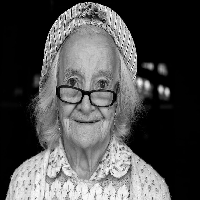

In [36]:
# Realizar predicciones sobre la imagen utilizando el modelo
a = genmodel.predict(images, batch_size=10)

# Comparar la salida de la predicción con un umbral (0.5) para determinar el género
if a < 0.5:
    print("Hombre")
else:
    print("Mujer")

# Mostrar la imagen
img

